## Long Short-Term Memory Network Model

## 1- Importing Required Libraries

In [1]:
# Importing Required Libraries
from   numpy                       import genfromtxt
from   sklearn.model_selection     import train_test_split
from   tflearn.layers.conv import conv_2d
from pylab import rcParams

import tflearn
import matplotlib
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import tensorflow        as tf

c:\users\reese\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


## 2- Loading LSTM Arranged Data

In [2]:
# Get all the Training data
All_Data = genfromtxt('All Data For LSTM.csv', delimiter=',')

# Select only the travel times data points (no hour, day, or month data are selected)
All_Data                  = All_Data[3:,:]  

# Defining the Number of Segments
number_of_segments = All_Data.shape[0]

## 3- Optional Data Augmentation Step: Quadruple the data by three points interpolation between every two succesive time points

In [3]:
# Number of Training Examples (n)
n                     = All_Data.shape[1]

# Initializing Matrix with 15-min Interpolated Data
A                     = np.empty((number_of_segments,4*n-3))

# Filling the Matrix with Nans
A[:,:]                = np.nan

# Defining the Indices of the Hourly Intervals
index_of_All_Data_in_A      = range(0,4*n-3,4)

# Filling the Hourly Intervals from The Original Data
A[:,index_of_All_Data_in_A] = All_Data

# Conversion to Dataframe to perform Interpolation Between the Hourly Intervals
df                    = pd.DataFrame(A.T)
df                    = df.interpolate()

# Convert Back to Numpy Array
All_Data_Interpolated = df.T.values

## 4- Optional Data Smoothing Step  (if window > 1)

In [4]:
# Smoothing Data if Desired
x                     = pd.rolling_mean(All_Data_Interpolated, window=1, min_periods=0,axis=1)

c:\users\reese\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  


## 5- Augmented Data Check

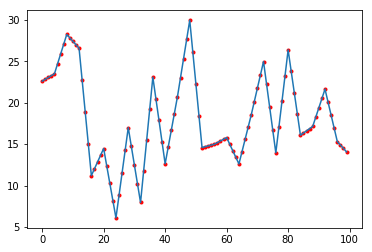

<Figure size 720x864 with 0 Axes>

In [5]:
# Plotting one of the segments (road) to spot check the correctness of augmented data
plt.plot(All_Data_Interpolated[3,0:100],'r.')
plt.plot( x[3,0:100])
plt.figure(figsize=(10,12))
plt.show()

## 6- Data Size Check

In [6]:
# Check the sizes of raw and smoothed data
print(All_Data_Interpolated.shape, x.shape)

(16, 105117) (16, 105117)


## 7- Time-sequenced Data Generation

In [7]:
# Generating Time-Sequenced Data and Setting Learning Rate
steps_of_history    =   24
steps_in_future     =   1
learning_rate       =  0.003
segments            = range(0,number_of_segments,1) 

number_travel_times = x.shape[1] 

samples             = number_travel_times - steps_of_history - steps_in_future

seq                 = np.zeros([samples, steps_of_history, number_of_segments])
next_val            = np.zeros([samples,                   number_of_segments])

for segment in range(number_of_segments):  
    for i in range(samples):
        seq     [i,:,segment] = x[ segment, i : i + steps_of_history                      ] 
        next_val[i,  segment] = x[ segment,     i + steps_of_history + steps_in_future - 1]
        
X      = seq
Y      = next_val
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.05)
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(99837, 24, 16) (99837, 16) (5255, 24, 16) (5255, 16)


## 8- Sequential Data Spot Check

In [8]:
print(X[steps_in_future,steps_of_history-1,:])
print(Y[0,:])

[28.13 17.75  5.85  6.1   4.12 46.22 12.38 12.46 17.61 12.28  9.42 43.43
 62.52 62.25 17.43 74.99]
[28.13 17.75  5.85  6.1   4.12 46.22 12.38 12.46 17.61 12.28  9.42 43.43
 62.52 62.25 17.43 74.99]


## 9- Creation and Execution of LSTM Model

In [9]:
# ----------------
# Network building
# ----------------
tf.reset_default_graph()

net = tflearn.input_data     (              shape = [None, steps_of_history, number_of_segments]
                             )
net = tflearn.lstm           ( net,       n_units = 96
                             ,         activation = 'relu'
                             ,         return_seq = False
                             )

net = tflearn.fully_connected( net,       n_units = number_of_segments
                             ,         activation = 'linear'
                             )
net = tflearn.regression     ( net,     optimizer = 'adam'
                             ,               loss = 'mean_square'
                             ,      learning_rate = learning_rate
                             )

# -----
# Train
# -----
model = tflearn.DNN          ( net
                             , tensorboard_verbose = 3
                             )
model.fit                    ( trainX, trainY
                             ,        n_epoch = 10
                             , validation_set = 0.0
                             ,     batch_size = 82
                             )


     
# -------------------------
# Predict the future values
# -------------------------
predicted_test   = model.predict(  testX )
predicted_train  = model.predict( trainX )
expected_test    = testY 
expected_train   = trainY 

Training Step: 12179  | total loss: 46.57613 | time: 31.114s
| Adam | epoch: 010 | loss: 46.57613 -- iter: 99794/99837
Training Step: 12180  | total loss: 44.25293 | time: 31.140s
| Adam | epoch: 010 | loss: 44.25293 -- iter: 99837/99837
--


## 10- Model Evaluation Metrics

In [10]:
# Importing and Creating Required Evaluation Metrics
from sklearn.metrics import mean_squared_error
import time

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
# Calculating the Mean Absolute Percentage Error (MAPE) for Each Segment
for i in range(16):
    print(mean_absolute_percentage_error(expected_test[:,i], predicted_test[:,i]))

7.655189810311273
14.045265449806957
14.784416346565074
15.227545121318967
16.61337327478263
5.0697021270736755
11.888892995356318
9.247298173886378
12.009164112519265
10.461360130548327
12.689803850205235
3.637661216973762
3.5237222082890485
4.171521334159857
4.554852762380054
4.1287070880763075


In [12]:
# Calculating the Total Training and Testing Root Mean Squared Errors and Mean Absolute Percentage Errors
rmseTest  = np.sqrt(mean_squared_error(expected_test,  predicted_test ))
rmseTrain = np.sqrt(mean_squared_error(expected_train, predicted_train))

mapeTest = mean_absolute_percentage_error(expected_test,  predicted_test )
mapeTrain= mean_absolute_percentage_error(expected_train, predicted_train)

print('----------------------------')
print('Test  RMSE: %.3f' % rmseTest )
print('Test  MAPE: %.3f' % mapeTest )
print('----------------------------')
print('Train RMSE: %.3f' % rmseTrain)
print('Train MAPE: %.3f' % mapeTrain)
print('----------------------------')


time.strftime('This run was conducted on %X %x %Z')

----------------------------
Test  RMSE: 4.950
Test  MAPE: 9.357
----------------------------
Train RMSE: 4.889
Train MAPE: 9.411
----------------------------


'This run was conducted on 15:00:36 01/08/19 Central Standard Time'

## 11- Plotting and Interpretation of Results

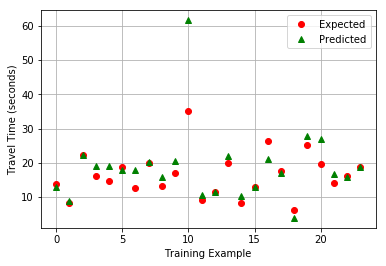

In [13]:
# Plotting predicted and expected travel times of first 50 steps in the 3rd segment 

#rcParams['figure.figsize'] = 5, 4       # To change figures sizes are needed

plt.plot( expected_test[0:24,3],'ro', label = "Expected" )
plt.plot(predicted_test[0:24,3],'g^', label = "Predicted")
plt.grid(True)
plt.legend()
plt.ylabel('Travel Time (seconds)')
plt.xlabel('Training Example')
plt.savefig('Random_Segment_24-Hour-Period')
plt.show()

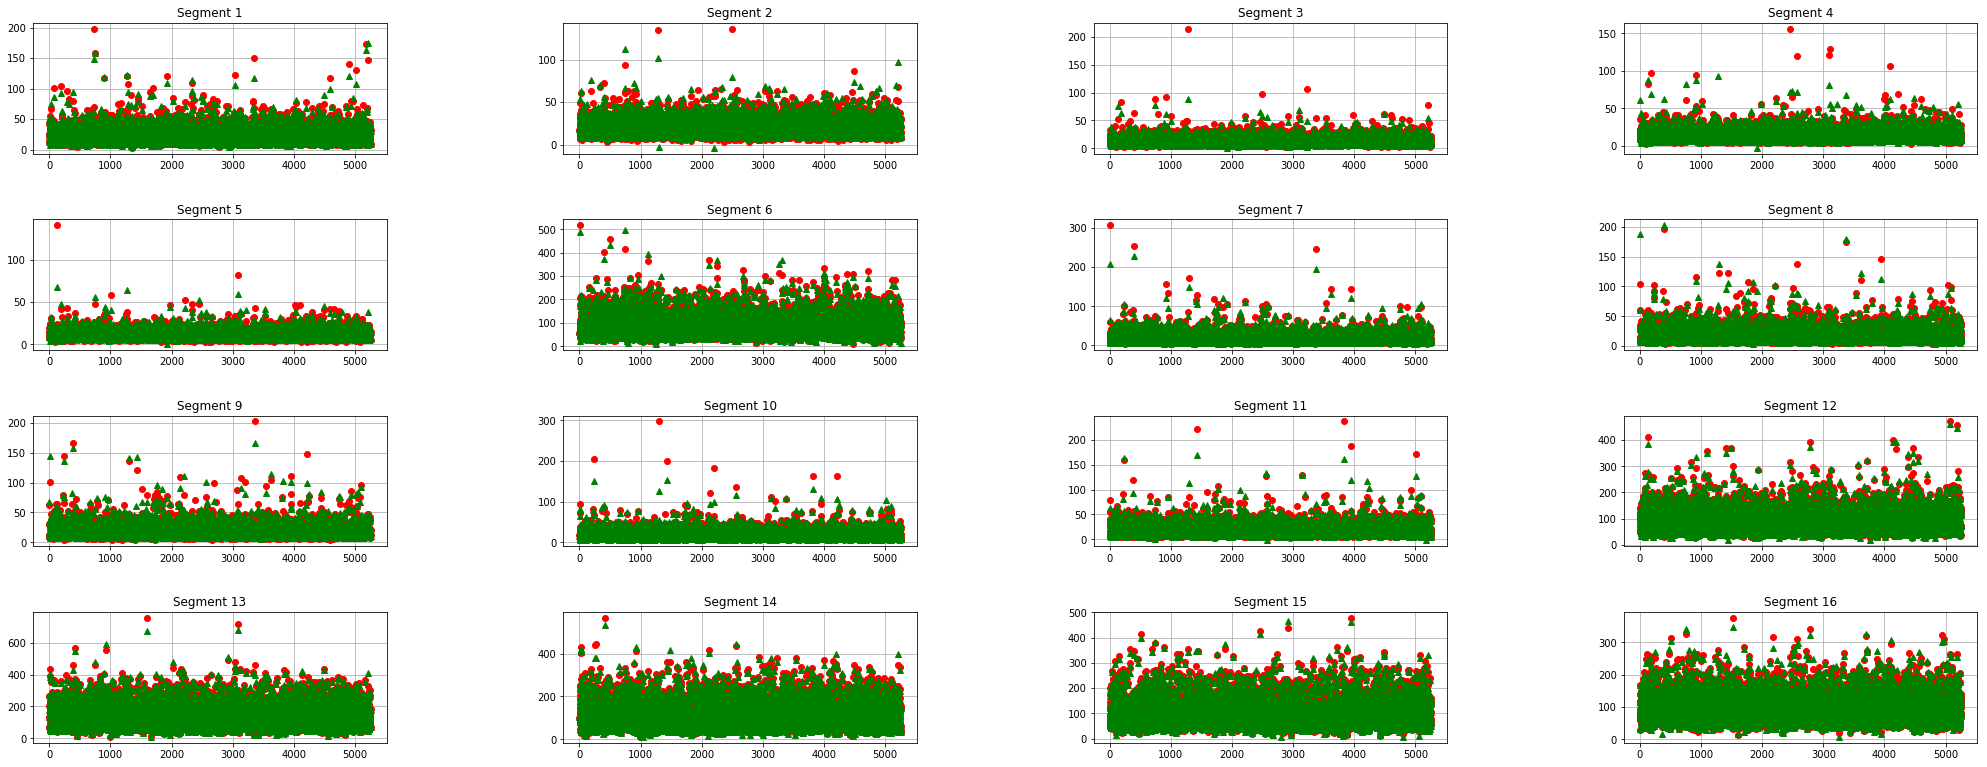

In [14]:
# Plotting predicted and expected travel times for the All segments an All times

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

plt.figure(1)
rcParams['figure.figsize'] = 15,15
for i in range(number_of_segments):
    plt.subplot(4,4,i+1)
    plt.plot( expected_test[:,i],'ro')
    plt.plot(predicted_test[:,i],'g^')
    plt.title( "Segment " + str(i+1))
    plt.grid(True)
    plt.savefig('Prediction All Segments LSTM')

plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=3, bottom=0.5, left=0.5, right=5, hspace=0.5,
                    wspace=0.5)

plt.show()

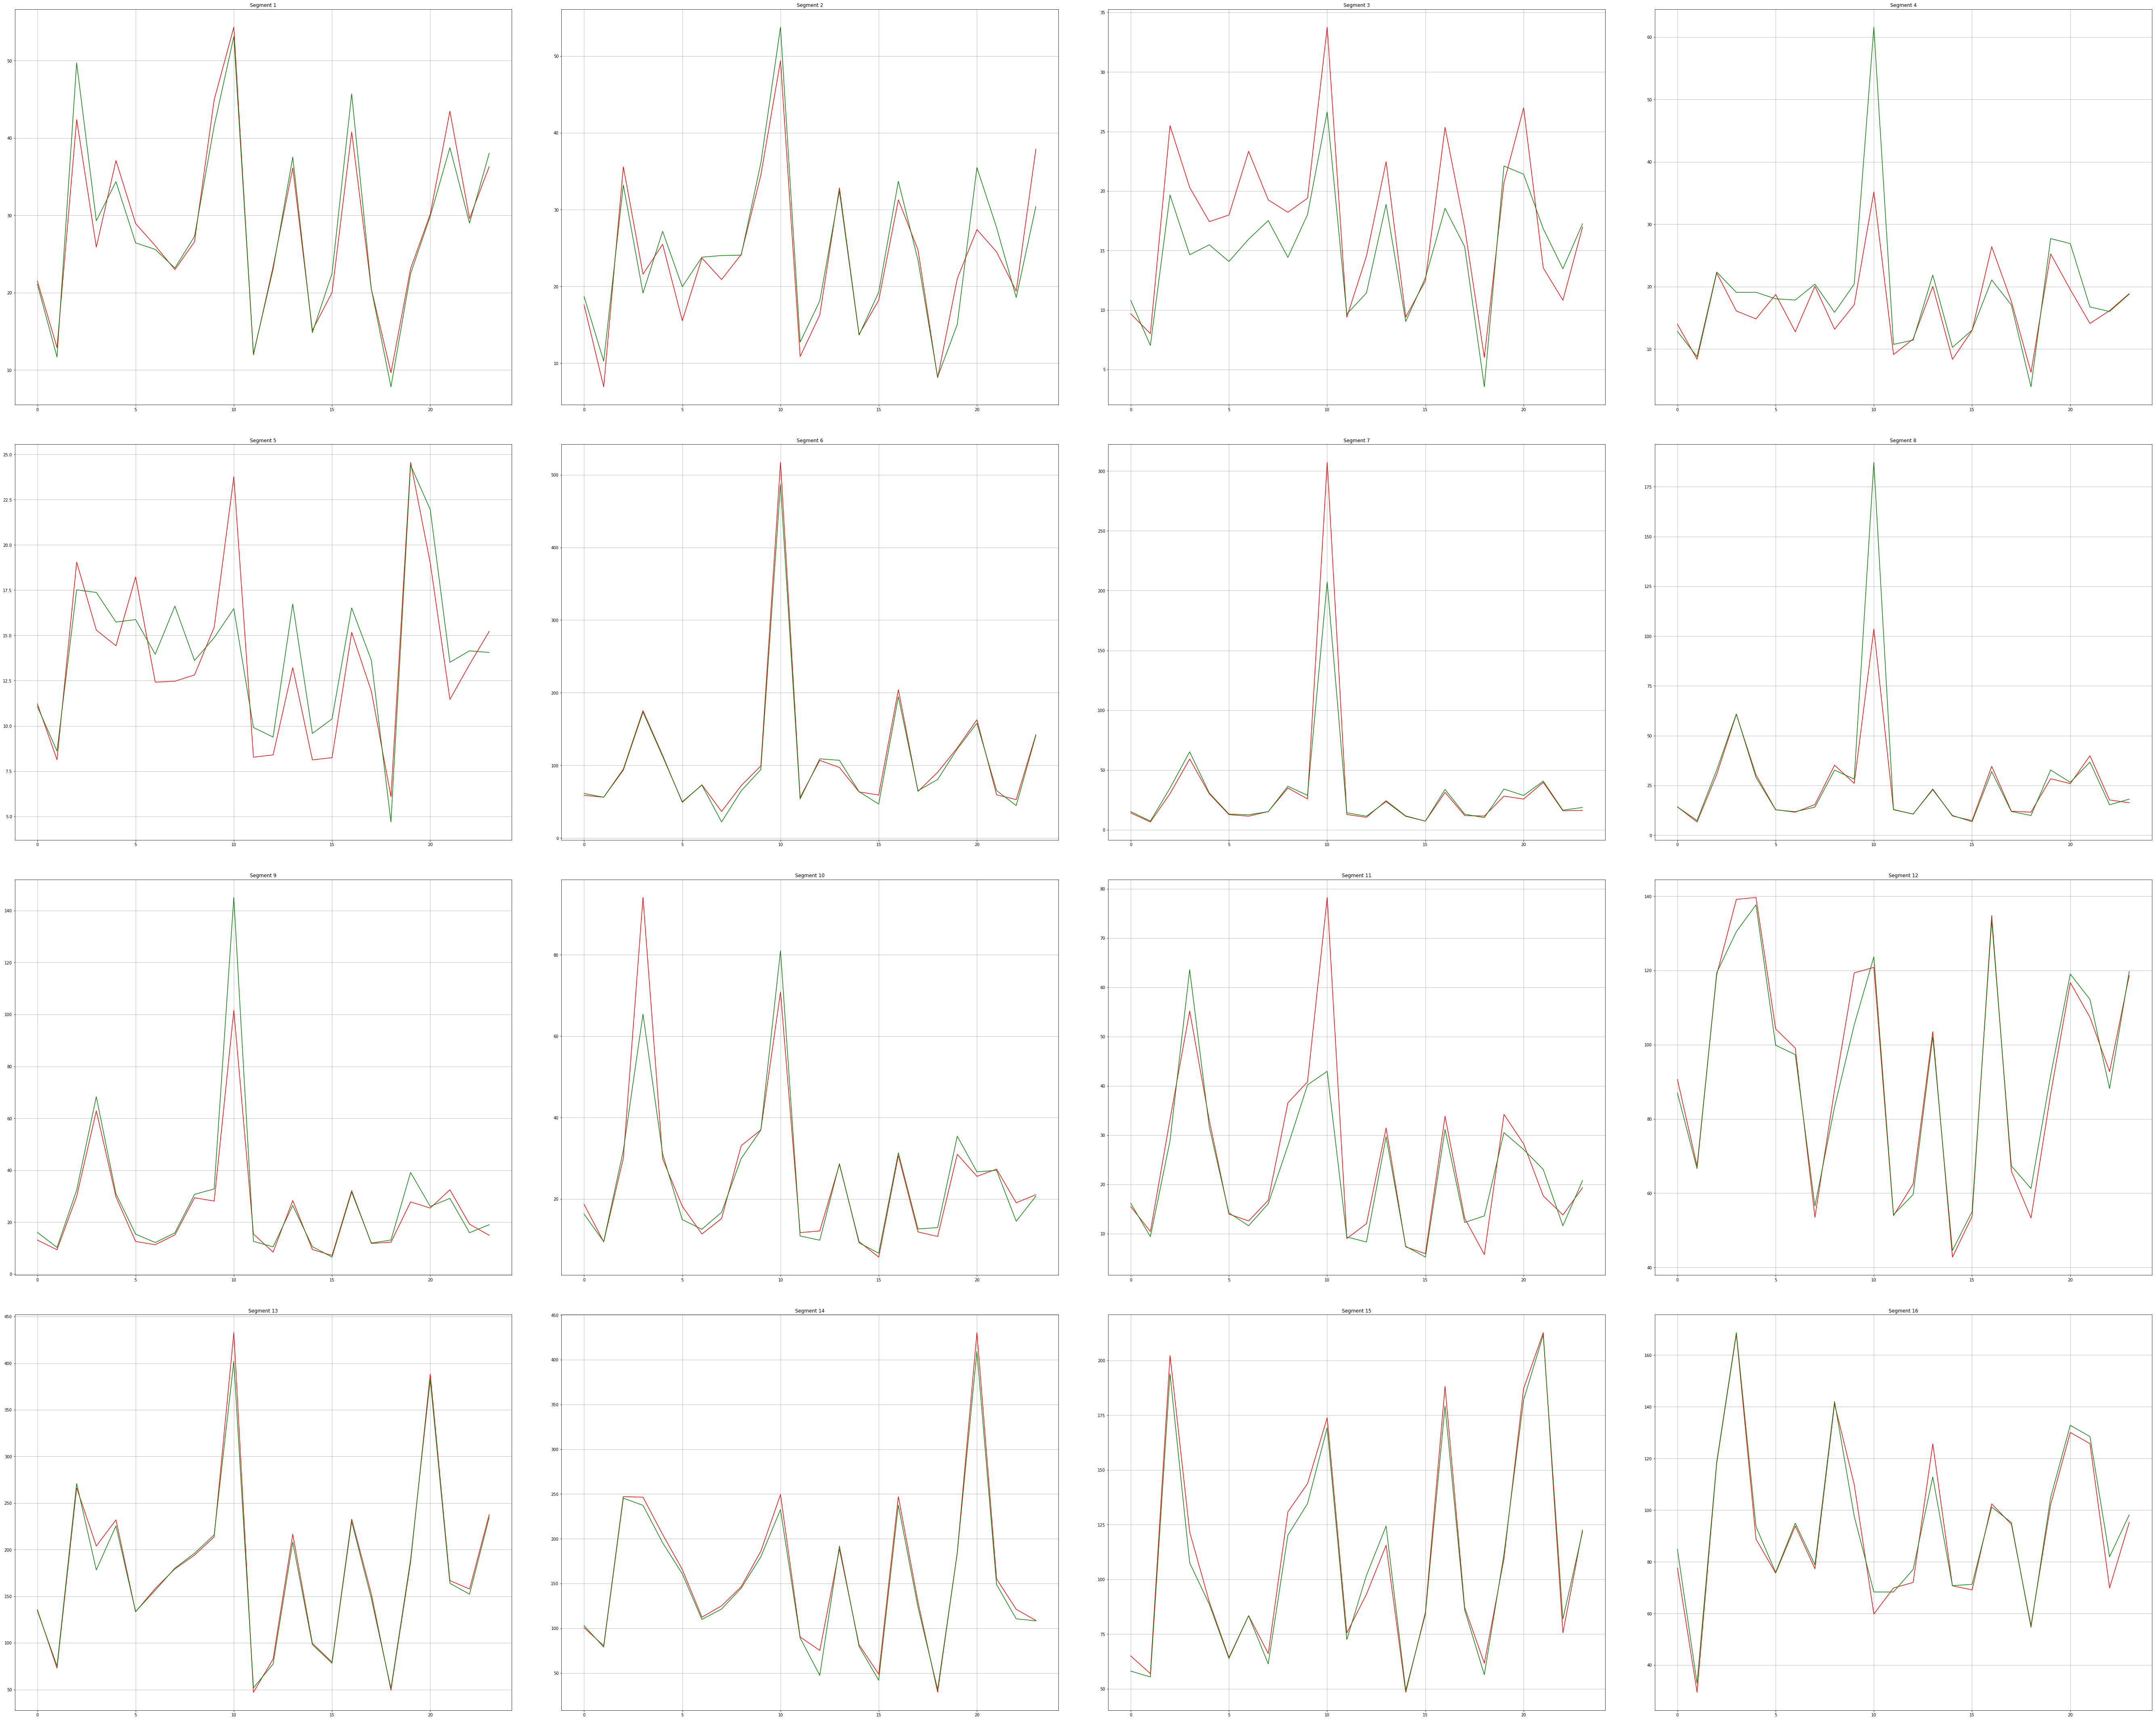

In [15]:
# Plotting predicted and expected travel times for the All segments for first 24 hours

# plot with various axes scales
plt.figure(1)

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot( expected_test[0:24,i],'r')
    plt.plot(predicted_test[0:24,i],'g')
    plt.title("Segment " +str(i+1))
    plt.grid(True)
    plt.savefig('Travel times for a Random 24-hour Period')

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=4, bottom=0.1, left=0.1, right=5, hspace=0.1,
                    wspace=0.1)

plt.show()

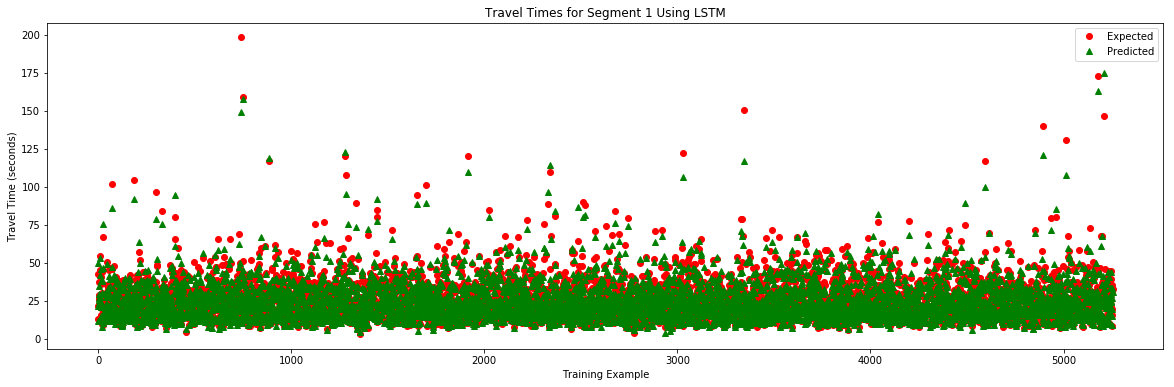

In [16]:
# Plotting predicted and expected travel times for Segment 1 only
#plt.figure(1)
rcParams['figure.figsize'] = 20, 6
plt.plot(expected_test[:,0],'ro', label = 'Expected')
plt.plot(predicted_test[:,0],'g^', label = 'Predicted')
plt.legend()
plt.ylabel('Travel Time (seconds)')
plt.xlabel('Training Example')
plt.title('Travel Times for Segment 1 Using LSTM')
plt.savefig('Travel Times for Segment 1 Using LSTM')
plt.show()

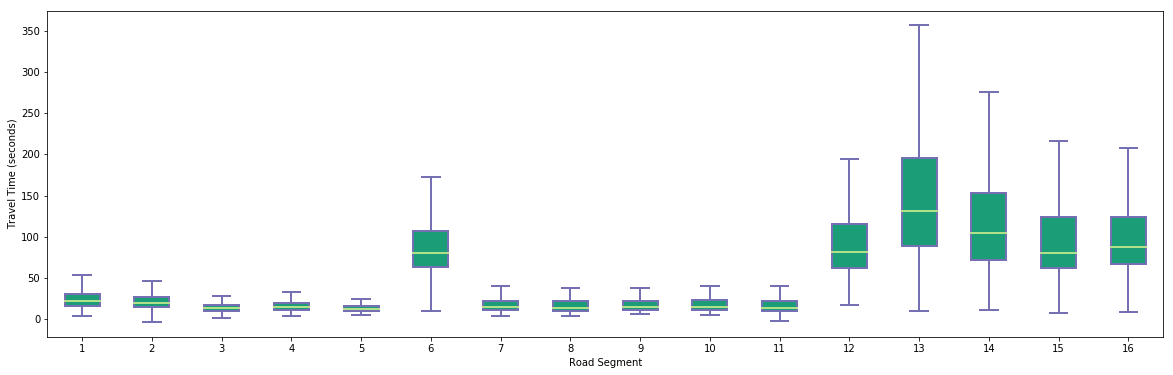

In [17]:
# Plotting Whisker Plots for all segments

fig = plt.figure(1)

# Create an axes instance
ax = fig.add_subplot(111)
plt.ylabel('Travel Time (seconds)')
plt.xlabel('Road Segment')
# Create the boxplot
bp = ax.boxplot(predicted_test, 0,'', patch_artist=True)

for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
# Save the figure
fig.savefig('Boxplot_LSTM', bbox_inches='tight')

In [18]:
# Computing cross correlation

for i in range(number_of_segments):
    for j in range(number_of_segments):
        cij = pd.np.corrcoef(predicted_test[:,i],expected_test[:,j])
cij[0][1].mean()

0.9917094993518396